# Preparando o ambiente

Importando todos os pacotes utilizados no projeto e carregandos as bases de dados.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [133]:
propostas = pd.read_csv('application_record.csv')
pagamentos = pd.read_csv('pagamentos_largo.csv')

## Entendendo os dados

**Marcação de bom e mau**

O objetivo da modelagem é classificar o risco de inadimplência (default). Neste caso, um cliente em default é aquele que está em 60 dias de atraso ou mais. Então classificaremos os clientes como 'bons' e 'maus' assim:

- **Maus pagadores**: são aqueles que entraram em default nos 24 meses seguintes à aquisição do cartão de crédito.
- **Bons pagadores**: são considerados todos os demais.
- **Excluídos**: Clientes que não adquiriram um cartão de crédito (seja por recusa, seja por desistência) não possuem informações de pagamento, portanto não se pode identificar se são bons ou maus.

**Bases disponíveis**

Temos duas bases: uma de propostas, com diversas informações dos vários solicitantes de cartão de crédito, e uma base de pagamentos. A base de pagamentos será utilizada para identificar a ocorrência de default. A base de propostas tem diversas informações coletadas no momento da solicitação do crédito.

As variáveis dessas bases são:


**Base de propostas - application_records.csv**

| Nome da Variável         | Description                                         | Tipo  |
| ------------------------ |:---------------------------------------------------:| -----:|
| ID| identificador do cliente (chave) |inteiro|
| CODE_GENDER| M = 'Masculino'; F = 'Feminino' |M/F|
| FLAG_OWN_CAR| Y = 'possui'; N = 'não possui' |Y/N|
| FLAG_OWN_REALTY| Y = 'possui'; N = 'não possui' |Y/N|
| CNT_CHILDREN| Quantidade de filhos |inteiro|
| AMT_INCOME_TOTAL| Annual income |inteiro|
| NAME_INCOME_TYPE|Tipo de renda (ex: assaliariado, autônomo etc) | texto |
| NAME_EDUCATION_TYPE| Nível de educação (ex: secundário, superior etc) |texto|
| NAME_FAMILY_STATUS | Estado civil (ex: solteiro, casado etc)| texto |
| NAME_HOUSING_TYPE | tipo de residência (ex: casa/apartamento, com os pais etc) | texto |
| DAYS_BIRTH | Count backwards from current day (0), -1 means yesterday |inteiro|
| DAYS_EMPLOYED | Count backwards from current day (0), -1 means yesterday |inteiro|
| FLAG_MOBIL | Indica se possui celular (1 = sim, 0 = não) |binária|
| FLAG_WORK_PHONE | Indica se possui telefone comercial (1 = sim, 0 = não) |binária|
| FLAG_PHONE | Indica se possui telefone (1 = sim, 0 = não) |binária|
| FLAG_EMAIL | Indica se possui e-mail (1 = sim, 0 = não) |binária|
| OCCUPATION_TYPE | Occupation	 |Qualitativa|
| CNT_FAM_MEMBERS | quantidade de pessoas na residência |inteiro|


**Base de pagamentos - pagamentos_largo.csv**  

| Nome da Variável         | Description                                         | Tipo  |
| ------------------------ |:---------------------------------------------------:| -----:|
| ID| identificador do cliente (chave) |inteiro|
| mes_00 a mes_24| faixa de atraso mês a mês do cliente <br>0: 1-29 days past due &nbsp;&nbsp;&nbsp;&nbsp; 1: 30-59 days past due <br />2: 60-89 days overdue &nbsp;&nbsp;&nbsp;&nbsp; 3: 90-119 days overdue <br /> 4: 120-149 days overdue &nbsp;&nbsp;&nbsp;&nbsp; 5: more than 150 days <br />C: paid off that month &nbsp;&nbsp;&nbsp;&nbsp; X: No loan for the month |Qualitativa|

# Preparando as bases de dados

In [134]:
# Visualizando a base de pagamentos

pagamentos.head()

,ID,mes_0,mes_1,mes_10,mes_11,mes_12,mes_13,mes_14,mes_15,mes_16,...,mes_22,mes_23,mes_24,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9
0,5001718,0,0,0,0,0,0,0,0,NaN,...,NaN,0,NaN,0,0,0,0,NaN,0,NaN
1,5001719,0,0,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
2,5001720,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,5001723,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN
4,5001726,0,0,C,C,C,C,C,C,C,...,C,C,C,0,0,0,C,C,C,C


In [135]:
# Removendo quaisquer linhas duplicadas na base

pagamentos = pagamentos.drop_duplicates()

In [136]:
# Marcando a ocorrência de default por mês para cada ID de usuário na base de pagamentos:

pagamentos['default'] = pagamentos.isin(['2', '3', '4', '5']).sum(axis = 1)
pagamentos['default'] = pagamentos['default'] > 0

In [137]:
# Marcando as ocorrências de default na base de propostas, com base nos dados da base de pagamentos:

propostas = propostas.merge(pagamentos, on = 'ID', how = 'left').drop(columns = pagamentos.columns[1:26])

Agora, na coluna default, proponentes que ainda não se tornaram clientes são marcados como *NaN*, os que cometeram default são marcados como *True* e os que não cometeram são marcados como *False*:

In [138]:
# Visualizando a base de propostas

propostas.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,default
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,NaN
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,NaN
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,False
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,NaN
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,NaN


Vemos abaixo a distribuição de default dentre os que se tornaram clientes (note que a base contém mais de 400 mil proponentes, mas menos de 17 mil se tornaram clientes):

In [139]:
# Quantidade de propostas, no geral:

propostas.shape[0]

438557

In [140]:
# Removendo quaisquer linhas duplicadas na base de propostas

propostas = propostas.drop_duplicates()

# Verificando quais variáveis contém dados faltantes

propostas.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
default                421907
dtype: int64

Note que a base contém mais de 438.557 proponentes, mas menos de 17 mil se tornaram clientes, por isso existem tantos dados vazios na variável default - isso era esperado.

Abaixo, observamos a diferença de quantidade entre clientes que cometeram e clientes que não cometeram default:

<Axes: xlabel='default', ylabel='count'>

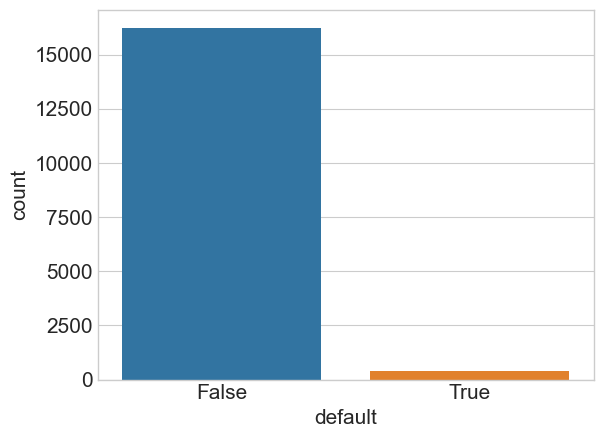

In [141]:
sns.countplot(data = propostas, x = 'default')

In [142]:
# Criando uma cópia da base de propostas

df = propostas

In [143]:
df['CNT_CHILDREN'].nunique()

12

# Preparando a base para um modelo de árvore de decisão

Nessa primeira fase, buscamos entender a distribuição da variável default em relação com as outras variáveis. Veremos quantos % de quem cometeu e de quem não cometeu default se enquadram em outras características.

In [144]:
# Criando um dtypes, observando a quantidade de variáveis por coluna do dataframe

df_dtypes = pd.DataFrame(df.dtypes)

lst = []

for i in df:
    val = df[f'{i}'].value_counts().shape[0]
    lst.append(val)
    
df_dtypes['qtd_categorias'] = lst

df_dtypes

,0,qtd_categorias
ID,int64,438510
CODE_GENDER,object,2
FLAG_OWN_CAR,object,2
FLAG_OWN_REALTY,object,2
CNT_CHILDREN,int64,12
AMT_INCOME_TOTAL,float64,866
NAME_INCOME_TYPE,object,5
NAME_EDUCATION_TYPE,object,5
NAME_FAMILY_STATUS,object,5
NAME_HOUSING_TYPE,object,6


In [145]:
# Criando dicionários vazios para armazenar dataframes de relação entre default e as outras variáveis

dataframes_quali_1 = {} # Variáveis qualitativas
dataframes_quali_2 = {} # Variáveis qualitativas
dataframes_quanti_1 = {} # Variáveis quantitativas


# Dois laços de repetição para armazenar os dataframes nas variáveis correspondentes

for column in df.columns[1:9]:
    if df[f'{column}'].nunique() < 18:
        x = pd.crosstab(df['default'], df[f'{column}'])
        x = x.div(x.sum(axis = 1), axis = 0)
        dataframes_quali_1[column] = x
        
    else: dataframes_quanti_1[column] = x


for column in df.columns[9:-1]:
    if df[f'{column}'].nunique() < 18:
        x = pd.crosstab(df['default'], df[f'{column}'])
        x = x.div(x.sum(axis = 1), axis = 0)
        dataframes_quali_2[column] = x
        
    else: dataframes_quanti_1[column] = x

In [146]:
# Definindo uma função para visualizar os gráficos de variáveis qualitativas

def show_graphs(dataframes):
    plt.figure(figsize = (11.25, 24))
    plt.suptitle ('Distribuição da variável default', size = 20, fontweight = 'bold')
    plt.rc('font', size = 15)
    
    for data in dataframes:
        i = list(dataframes.keys()).index(data) + 1
        axes = plt.subplot(5, 2, i)
        df = dataframes[data]
        df.plot.bar(ax = axes).tick_params(axis='both', rotation = 0, labelsize = 13)
        axes.set_title(f'por {df.columns.name}', fontsize = 'small')
        axes.legend(fontsize = 'xx-small', loc = 'best')
        axes.axes.get_xaxis().get_label().set_visible(False)
    
    plt.show()

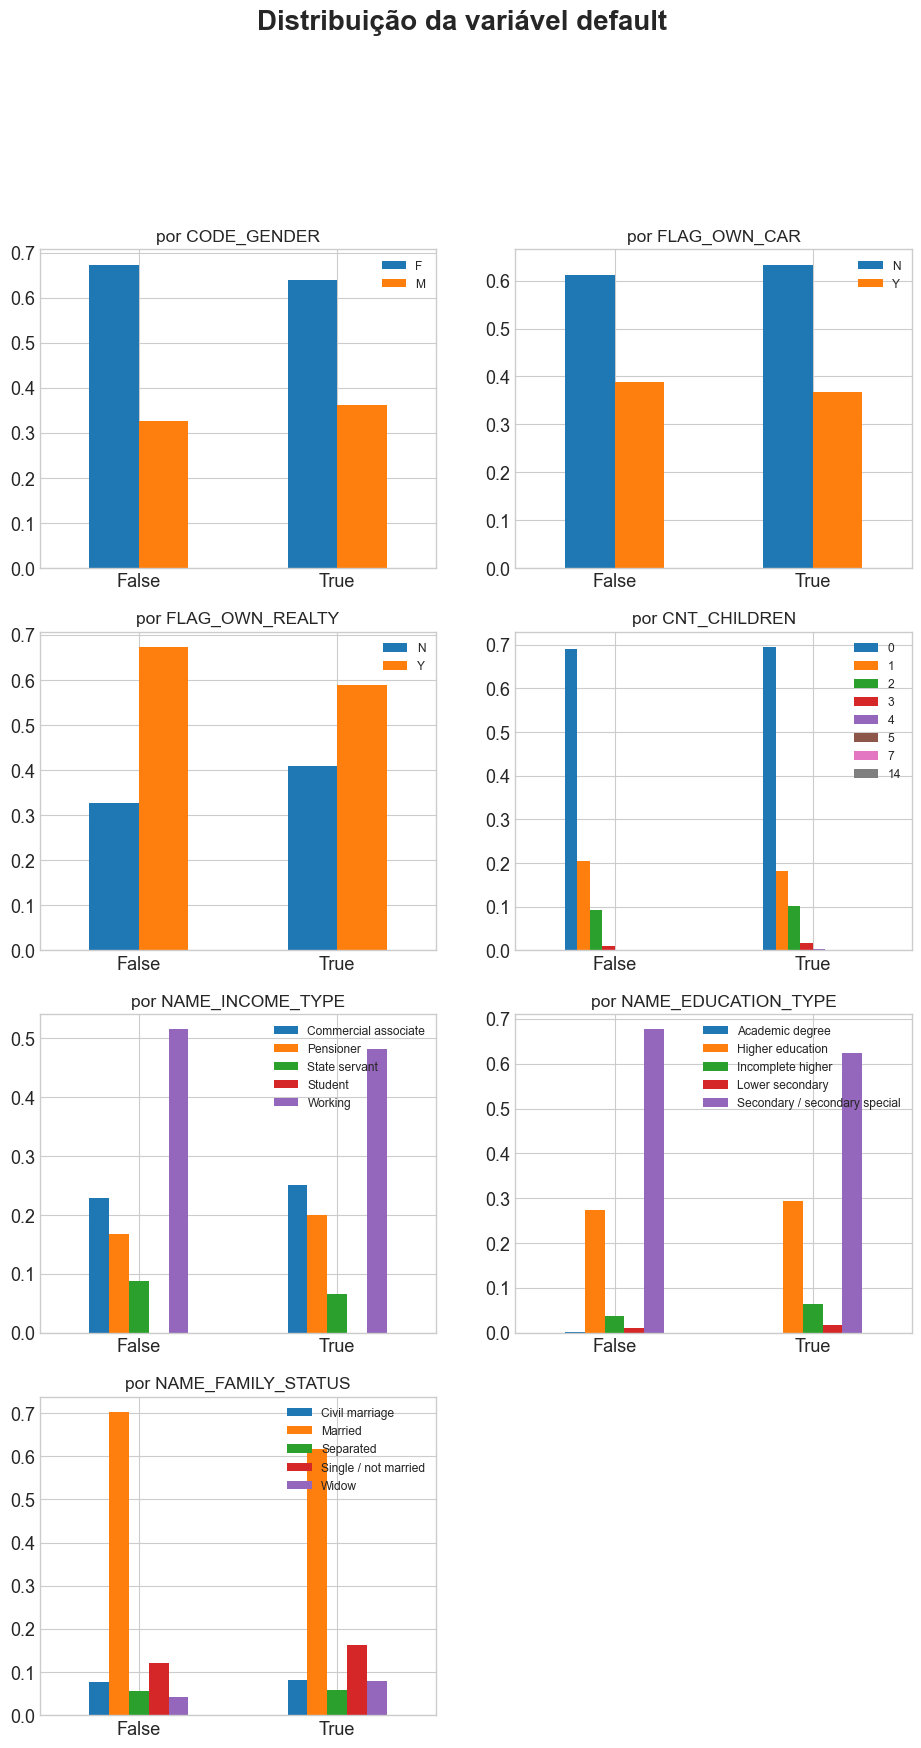

In [147]:
# Visualizando a primeira leva de gráficos qualitativos

show_graphs(dataframes_quali_1)

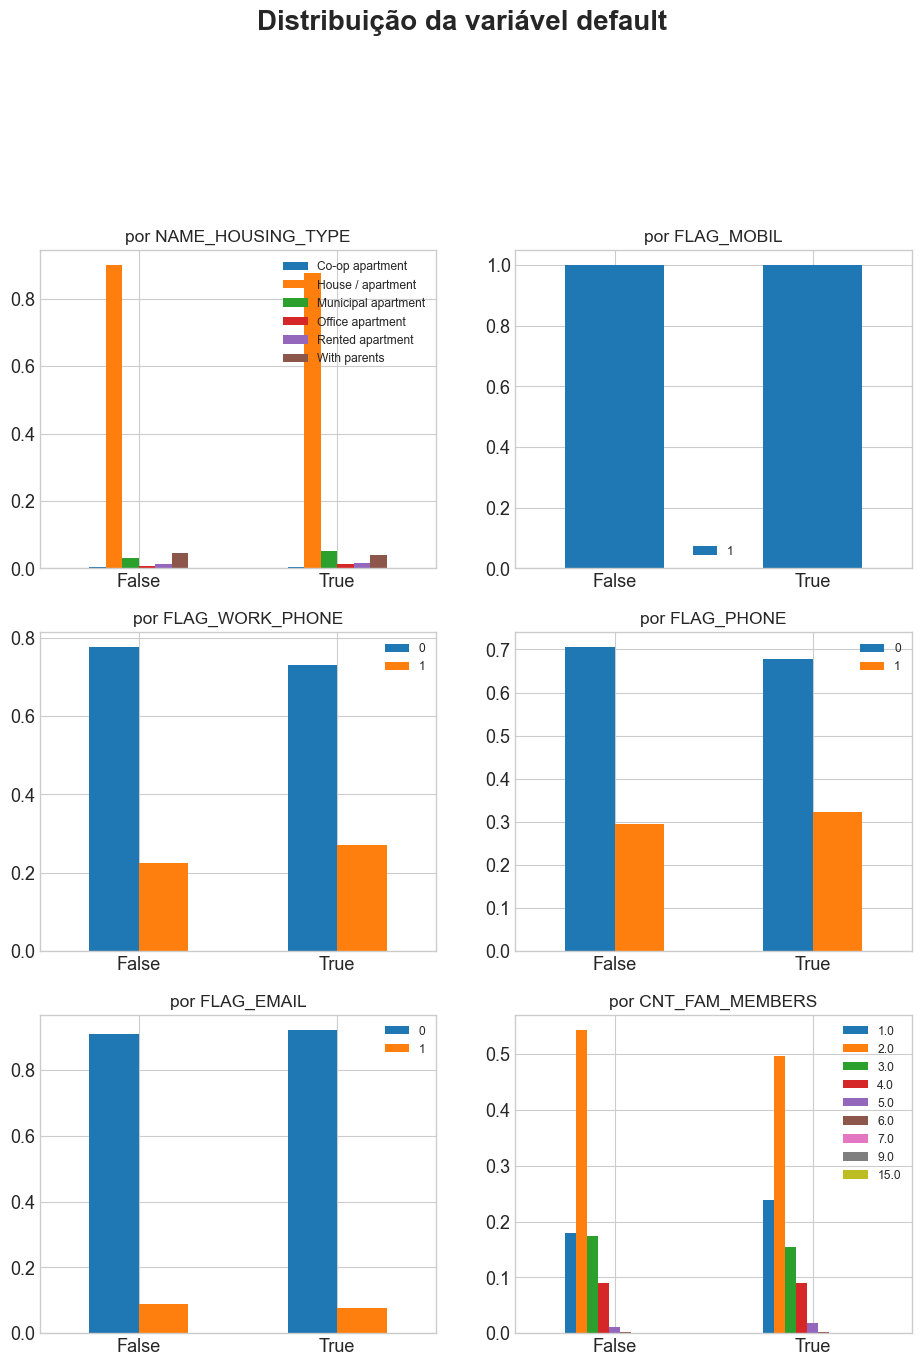

In [148]:
# Visualizando a segunda leva de gráficos qualitativos

show_graphs(dataframes_quali_2)

In [149]:
# Visualizando quais são os dataframes restantes

dataframes_quanti_1.keys()

dict_keys(['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE'])

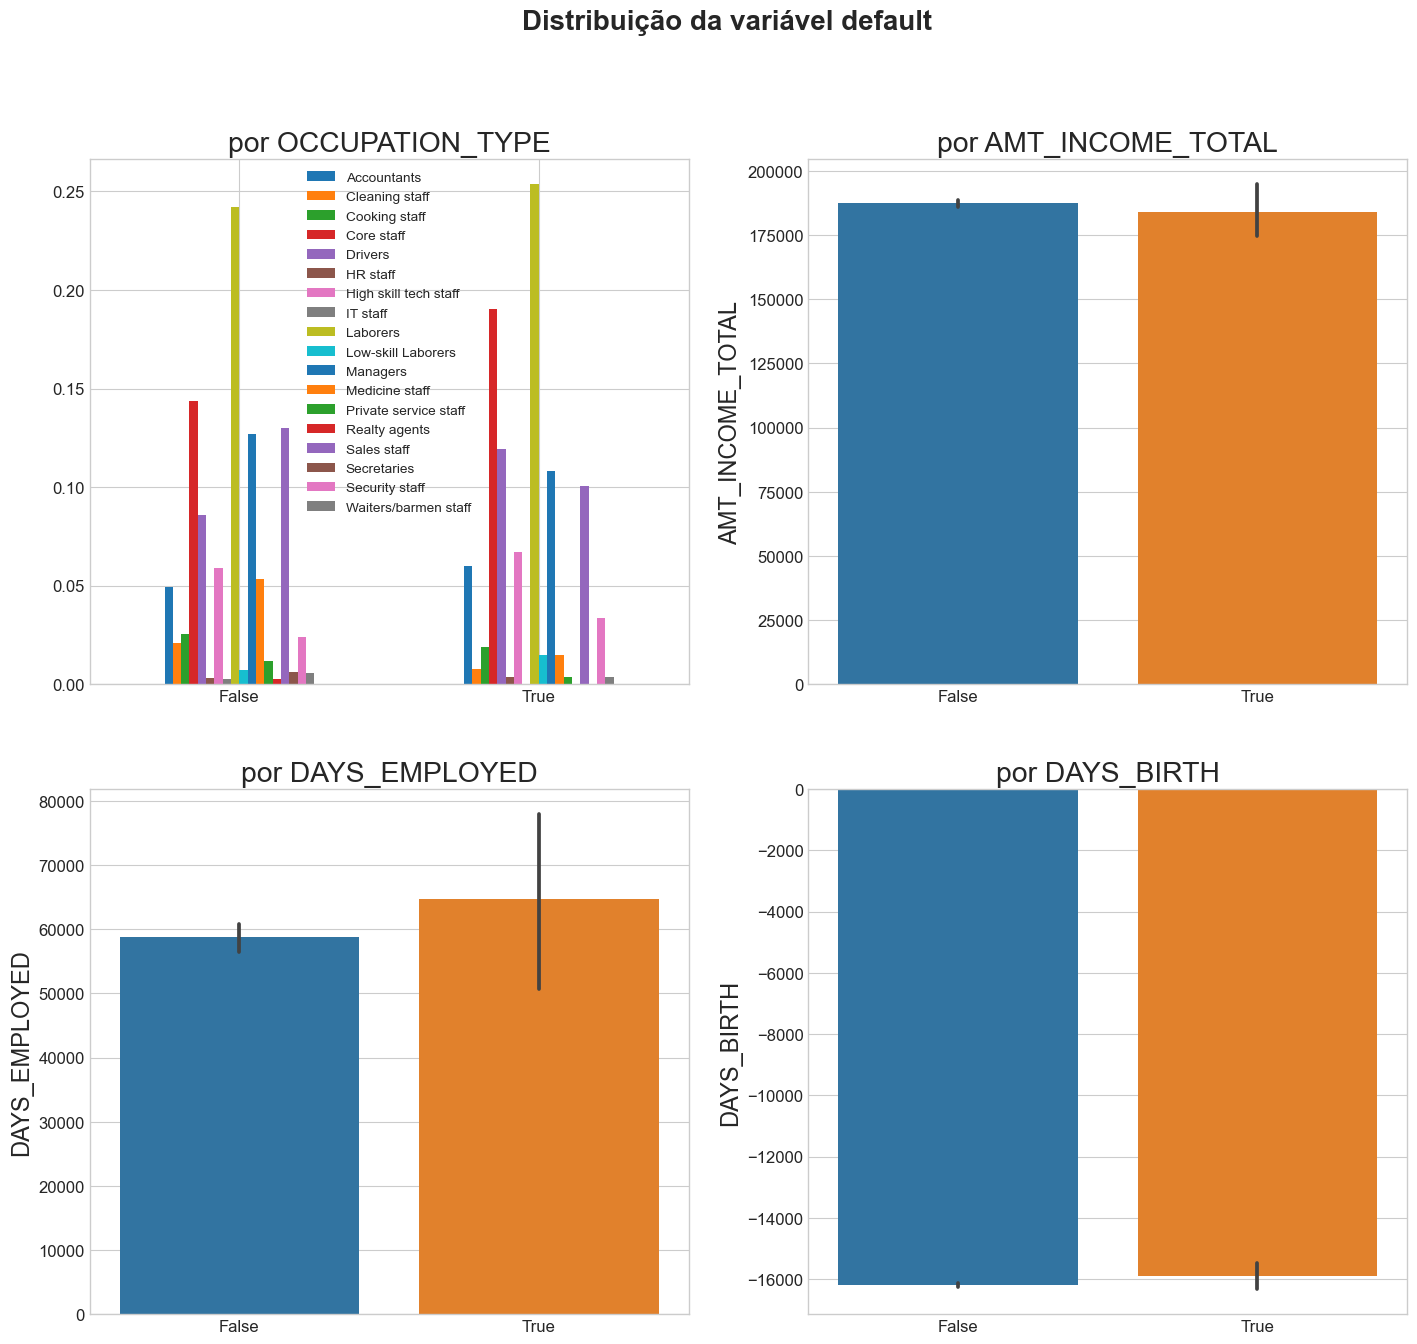

In [150]:
# Criando uma figura

plt.figure(figsize = (17, 15))
plt.suptitle ('Distribuição da variável default', size = 20, fontweight = 'bold')
plt.rc('font', size = 17)


# Criando os gráficos quantitativos

ax1 = plt.subplot(2, 2, 1) # Este é qualitativo, porém contém muitas variáveis, o que torna inviável o criar em uma função
ocup_default = pd.crosstab(df['default'], df['OCCUPATION_TYPE'])
ocup_default = ocup_default.div(ocup_default.sum(axis = 1), axis = 0)
ocup_default.plot.bar(ax = ax1).tick_params(axis = 'both', rotation = 0, labelsize = 12)
ax1.set_title('por OCCUPATION_TYPE')
ax1.legend(loc = 'upper center', fontsize = 'xx-small')
ax1.axes.get_xaxis().get_label().set_visible(False)

ax2 = plt.subplot(2, 2, 2)
sns.barplot(ax = ax2, data=df, x = 'default', y = 'AMT_INCOME_TOTAL').tick_params(axis = 'both', rotation = 0, labelsize = 12)
ax2.set_title('por AMT_INCOME_TOTAL')
ax2.axes.get_xaxis().get_label().set_visible(False)

ax3 = plt.subplot(2, 2, 3)
sns.barplot(ax = ax3, data = df, y = 'DAYS_EMPLOYED', x = 'default').tick_params(axis = 'both', rotation = 0, labelsize = 12)
ax3.set_title('por DAYS_EMPLOYED')
ax3.axes.get_xaxis().get_label().set_visible(False)

ax4 = plt.subplot(2, 2, 4)
sns.barplot(ax = ax4, data = df, y = 'DAYS_BIRTH', x = 'default').tick_params(axis = 'both', rotation = 0, labelsize = 12)
ax4.set_title('por DAYS_BIRTH')
ax4.axes.get_xaxis().get_label().set_visible(False)

plt.show();

Observando todoos gráficos acima, percebemos que não há uma diferença impactante na distribuição de default para nenhuma das variáveis. Nenhuma delas pode se relacionar diretamente com a ocorrência do default.

Para que o scikit-learn possa interpretar os nossos dados, criaremos variáveis dummy para as variáveis qualitativas. Elas precisam estar armazenadas como binárias (0/1). Após isso, removemos as qualitativas que não estão armazenadas como dummy.

In [151]:
# Criando uma cópia dos dados

df_copy = df


# Transformando as colunas com apenas 2 variáveis em dummy

mappings = {'F': 0, 'M': 1}
df_copy['CODE_GENDER'] = df_copy['CODE_GENDER'].map(mappings)
df_copy = df_copy.rename(columns = {'CODE_GENDER': 'GENDER_M'})

mappings = {'N': 0, 'Y': 1}
df_copy['FLAG_OWN_CAR'] = df_copy['FLAG_OWN_CAR'].map(mappings)

df_copy['FLAG_OWN_REALTY'] = df_copy['FLAG_OWN_REALTY'].map(mappings)


# Criando dataframes com variáveis dummy para as colunas com mais de duas variáveis

dummiesNAME_INCOME_TYPE = pd.get_dummies(df['NAME_INCOME_TYPE']).astype(int)
dummiesNAME_INCOME_TYPE['ID'] = df['ID']
dummiesNAME_INCOME_TYPE.rename(columns = {'Working': 'NAME_INCOME_TYPE_Working',
                                          'Commercial associate': 'NAME_INCOME_TYPE_Commercial_associate',
                                          'Pensioner': 'NAME_INCOME_TYPE_Pensioner',
                                          'State servant': 'NAME_INCOME_TYPE_State_servant',
                                          'Student': 'NAME_INCOME_TYPE_Student'}, inplace=True)

dummiesNAME_EDUCATION_TYPE = pd.get_dummies(df['NAME_EDUCATION_TYPE']).astype(int)
dummiesNAME_EDUCATION_TYPE['ID'] = df['ID']
dummiesNAME_EDUCATION_TYPE.rename(columns = {'Secondary / secondary special': 'NAME_EDUCATION_TYPE_Secondary/secondary_special',
                                             'Higher education': 'NAME_EDUCATION_TYPE_Higher_education',
                                             'Incomplete higher': 'NAME_EDUCATION_TYPE_Incomplete_higher',
                                             'Lower secondary': 'NAME_EDUCATION_TYPE_Lower_secondary',
                                             'Academic degree': 'NAME_EDUCATION_TYPE_Academic_degree'}, inplace=True)

dummiesNAME_FAMILY_STATUS = pd.get_dummies(df['NAME_FAMILY_STATUS']).astype(int)
dummiesNAME_FAMILY_STATUS['ID'] = df['ID']
dummiesNAME_FAMILY_STATUS.rename(columns = {'Married': 'NAME_FAMILY_STATUS_Married',
                                            'Single / not married': 'NAME_FAMILY_STATUS_Single/not_married',
                                            'Civil marriage': 'NAME_FAMILY_STATUS_Civil_marriage',
                                            'Separated': 'NAME_FAMILY_STATUS_Separated',
                                            'Widow': 'NAME_FAMILY_STATUS_Widow'}, inplace=True)

dummiesNAME_HOUSING_TYPE = pd.get_dummies(df['NAME_HOUSING_TYPE']).astype(int)
dummiesNAME_HOUSING_TYPE['ID'] = df['ID']
dummiesNAME_HOUSING_TYPE.rename(columns = {'House / apartment': 'NAME_HOUSING_TYPE_House/apartment',
                                           'With parents': 'NAME_HOUSING_TYPE_With_parents',
                                           'Municipal apartment': 'NAME_HOUSING_TYPE_Municipal_apartment',
                                           'Rented apartment': 'NAME_HOUSING_TYPE_Rented_apartment',
                                           'Office apartment': 'NAME_HOUSING_TYPE_Office_apartment',
                                           'Co-op apartment': 'NAME_HOUSING_TYPE_Co-op_apartment'}, inplace=True)

dummiesOCCUPATION_TYPE = pd.get_dummies(df['OCCUPATION_TYPE']).astype(int)
dummiesOCCUPATION_TYPE['ID'] = df['ID']
dummiesOCCUPATION_TYPE.rename(columns = {'Laborers': 'OCCUPATION_TYPE_Laborers',
                                         'Core staff': 'OCCUPATION_TYPE_Core_staff',
                                         'Sales staff': 'OCCUPATION_TYPE_Sales_staff',
                                         'Managers': 'OCCUPATION_TYPE_Managers',
                                         'Drivers': 'OCCUPATION_TYPE_Drivers',
                                         'High skill tech staff': 'OCCUPATION_TYPE_High_skill_tech_staff',
                                         'Accountants': 'OCCUPATION_TYPE_Accountants',
                                         'Medicine staff': 'OCCUPATION_TYPE_Medicine_staff',
                                         'Cooking staff': 'OCCUPATION_TYPE_Cooking_staff',
                                         'Security staff': 'OCCUPATION_TYPE_Security_staff',
                                         'Cleaning staff': 'OCCUPATION_TYPE_Cleaning_staff',
                                         'Private service staff': 'OCCUPATION_TYPE_Private_service_staff',
                                         'Low-skill Laborers': 'OCCUPATION_TYPE_Low-skill_Laborers',
                                         'Secretaries': 'OCCUPATION_TYPE_Secretaries',
                                         'Waiters/barmen staff': 'OCCUPATION_TYPE_Waiters/barmen_staff',
                                         'Realty agents': 'OCCUPATION_TYPE_Realty_agents',
                                         'HR staff': 'OCCUPATION_TYPE_HR_staff',
                                         'IT staff': 'OCCUPATION_TYPE_IT_staff'}, inplace=True)

In [152]:
# Adicionando ao dataframe os dataframes dummy criados anteriormente

df_copy = df_copy.merge(dummiesNAME_INCOME_TYPE, on = 'ID', how = 'left')
df_copy = df_copy.merge(dummiesNAME_EDUCATION_TYPE, on = 'ID', how = 'left')
df_copy = df_copy.merge(dummiesNAME_FAMILY_STATUS, on = 'ID', how = 'left')
df_copy = df_copy.merge(dummiesNAME_HOUSING_TYPE, on = 'ID', how = 'left')
df_copy = df_copy.merge(dummiesOCCUPATION_TYPE, on = 'ID', how = 'left')
df_copy.columns

Index(['ID', 'GENDER_M', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'default',
       'NAME_INCOME_TYPE_Commercial_associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State_servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic_degree',
       'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_EDUCATION_TYPE_Incomplete_higher',
       'NAME_EDUCATION_TYPE_Lower_secondary',
       'NAME_EDUCATION_TYPE_Secondary/secondary_special',
       'NAME_FAMILY_STATUS_Civil_marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single/not_married',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op_apartment',
   

In [153]:
# Removendo as colunas que tiveram seus dados transformados em dummy e quaisquer duplicatas restantes

df_copy = df_copy.drop(columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                  'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])

df_copy.drop_duplicates()

,ID,GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters/barmen_staff
0,5008804,1,1,1,0,427500.0,-12005,-4542,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5008805,1,1,1,0,427500.0,-12005,-4542,1,1,...,0,0,0,0,0,0,0,0,0,0
2,5008806,1,1,1,0,112500.0,-21474,-1134,1,0,...,0,0,0,0,0,0,0,0,1,0
3,5008808,0,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5008809,0,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441466,6840104,1,0,1,0,135000.0,-22717,365243,1,0,...,0,0,0,0,0,0,0,0,0,0
441467,6840222,0,0,0,0,103500.0,-15939,-3007,1,0,...,1,0,0,0,0,0,0,0,0,0
441468,6841878,0,0,0,0,54000.0,-8169,-372,1,1,...,0,0,0,0,0,0,1,0,0,0
441469,6842765,0,0,1,0,72000.0,-21673,365243,1,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
# Visualizando o dataframe, agora todas as variáveis qualitativas transformadas em dummy

df_copy.head()

,ID,GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters/barmen_staff
0,5008804,1,1,1,0,427500.0,-12005,-4542,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5008805,1,1,1,0,427500.0,-12005,-4542,1,1,...,0,0,0,0,0,0,0,0,0,0
2,5008806,1,1,1,0,112500.0,-21474,-1134,1,0,...,0,0,0,0,0,0,0,0,1,0
3,5008808,0,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5008809,0,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0


In [155]:
# Visualizando as colunas com dados faltantes

df_copy.isnull().sum()

ID                                                      0
GENDER_M                                                0
FLAG_OWN_CAR                                            0
FLAG_OWN_REALTY                                         0
CNT_CHILDREN                                            0
AMT_INCOME_TOTAL                                        0
DAYS_BIRTH                                              0
DAYS_EMPLOYED                                           0
FLAG_MOBIL                                              0
FLAG_WORK_PHONE                                         0
FLAG_PHONE                                              0
FLAG_EMAIL                                              0
CNT_FAM_MEMBERS                                         0
default                                            424821
NAME_INCOME_TYPE_Commercial_associate                   0
NAME_INCOME_TYPE_Pensioner                              0
NAME_INCOME_TYPE_State_servant                          0
NAME_INCOME_TY

# Árvore de decisão

Agora, vamos separar os dados em conjuntos de treino e teste. Depois, vamos treinar e rodar o modelo de árvore de decisão nos dados de treino e de teste.

In [156]:
# Criando uma nova base de dados, sem os dados vazios

X = df_copy.dropna()

y = X.default
y = y.astype(int)

X = X.drop(columns = ['default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

Árvore de decisão nos dados de treino:

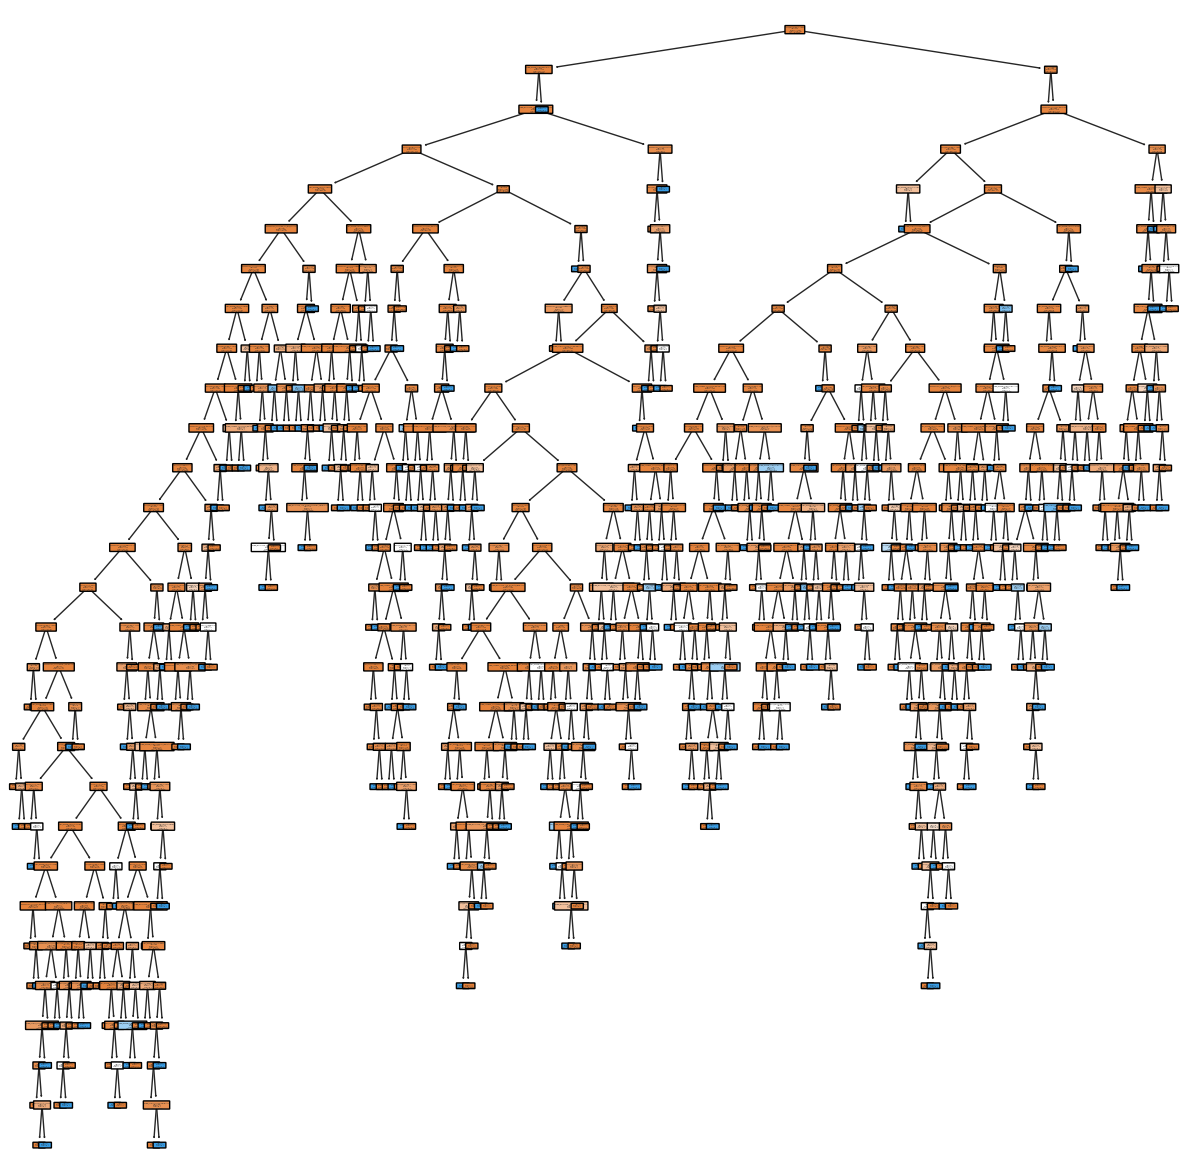

In [157]:
# Definindo um objeto com a função da árvore de decisão

clf = DecisionTreeClassifier(random_state = 100)


# Treinando o modelo com os dados separados para treinamento

clf = clf.fit(X_train, y_train)


# Visualizando a estrutura da árvore gerada

plt.figure(figsize=[15, 15])
plot_tree(clf,
         filled = True,
         rounded = True,
         class_names = ['aprovados', 'reprovados'],
         feature_names = list(X_train.columns));

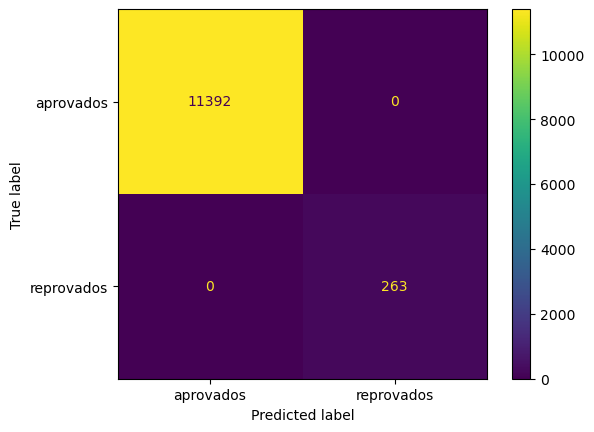

In [158]:
# Visualizando a matriz de confusão nos dados de treino

plt.style.use('default')

predict_train = clf.predict(X_train)

cm = confusion_matrix(y_train, predict_train, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ['aprovados', 'reprovados'])

disp.plot()
plt.show()

In [159]:
# Calculando a acurácia na base de treinamento

acc_train = accuracy_score(y_train, predict_train)
acc_train

1.0

Árvore de decisão nos dados de teste:

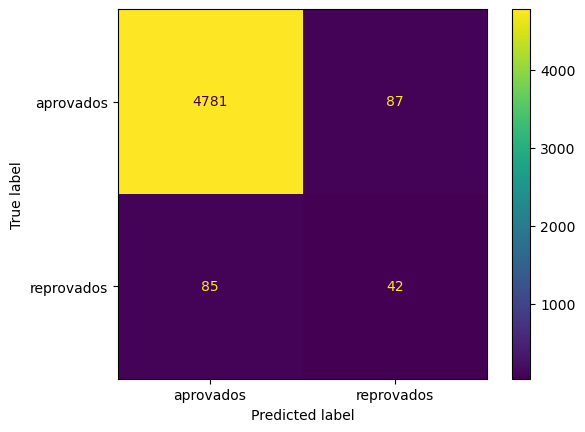

In [160]:
# Classificando a base de teste de acordo com a árvore que treinamos com os dados de treino

predict_test = clf.predict(X_test)


# Visualizando a matriz de confusão na base de teste

cm = confusion_matrix(y_test, predict_test, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ['aprovados', 'reprovados'])

disp.plot()
plt.show()

In [161]:
# Calculando a acurácia da base de teste

acc_test = accuracy_score(y_test, predict_test)
acc_test

0.9655655655655656

Criando uma nova árvore de decisão, com alguns parâmetros de controle adicionais:

In [162]:
# Definindo uma nova árvore

clf = DecisionTreeClassifier(random_state = 123,
                             max_depth = 10, # Máximo de profundidade de 10
                             min_samples_leaf = 5) # Mínimo de observações por folha de 5


# Treinando o modelo com a nova árvore

clf = clf.fit(X_train, y_train)

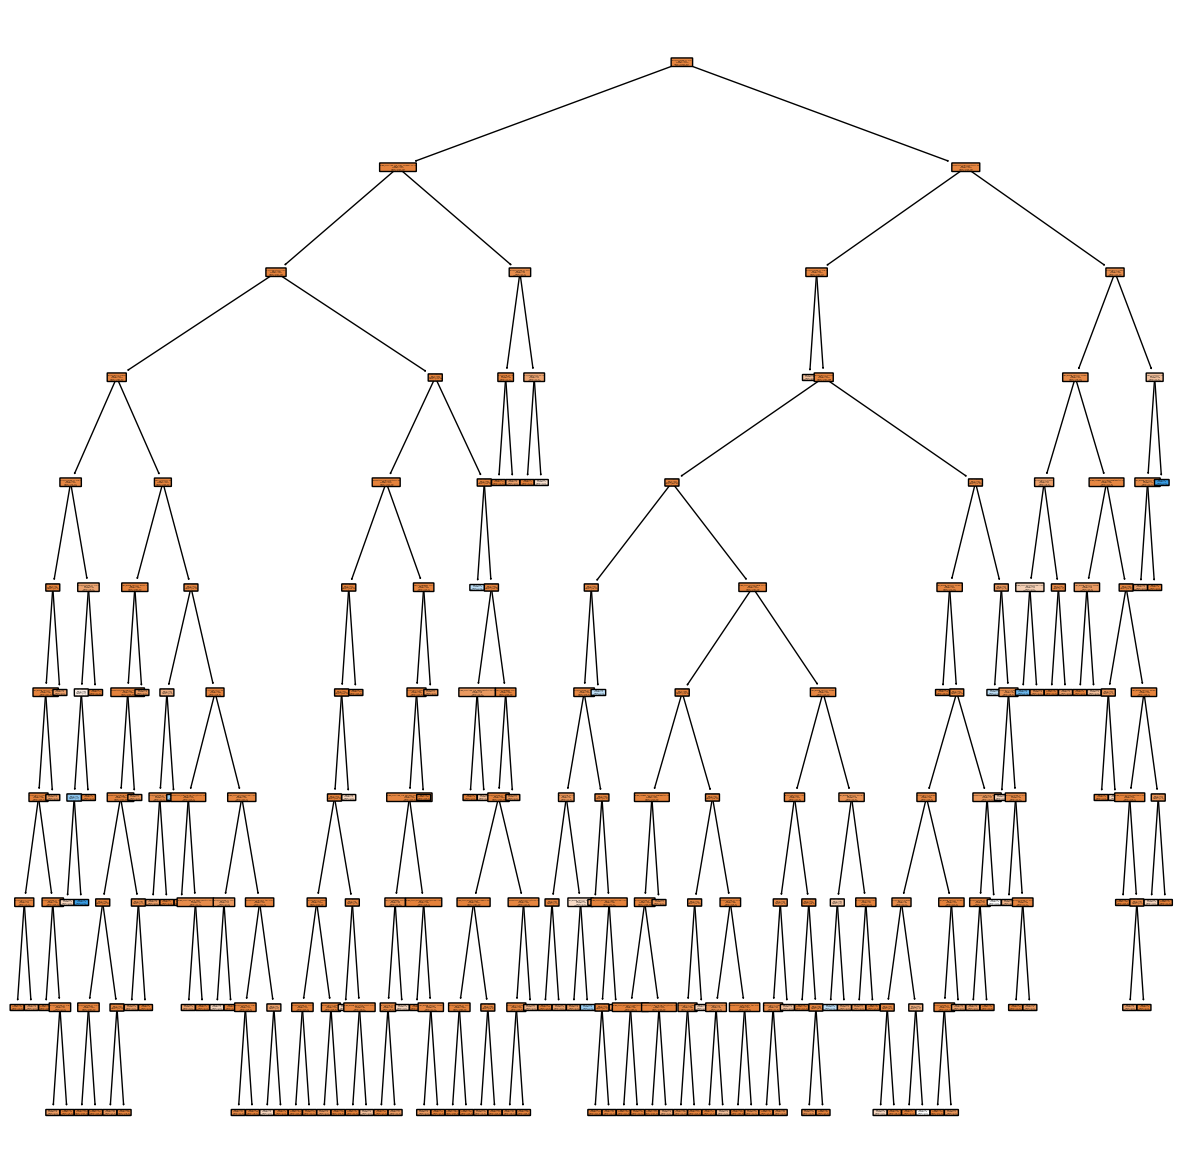

In [163]:
# Visualizando a estrutura da nova árvore

plt.figure(figsize = [15, 15])
plot_tree(clf,
         filled = True,
         rounded = True,
         class_names= ['aprovados', 'reprovados'],
         feature_names = list(X_train.columns));

Verificando os resultados da nova árvore na base de teste:

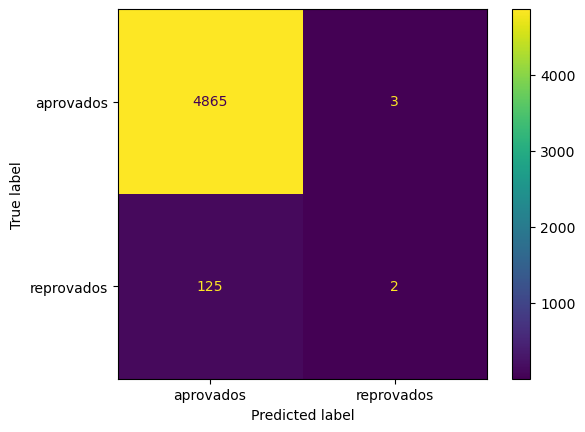

In [164]:
# Classificando a base de teste de acordo com o novo treinamento

predict_test = clf.predict(X_test)


# Visualizando a matriz de confusão

cm = confusion_matrix(y_test, predict_test, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ['aprovados', 'reprovados'])

disp.plot()
plt.show()

In [165]:
# Verificando a acurácia

acc_test = accuracy_score(y_test, predict_test)
acc_test

0.9743743743743744

In [166]:
# Verificando a proporção de propontentes classificados como maus

5 / (4865 + 3 + 125 + 2)

0.001001001001001001

In [167]:
# Qual seria a acurácia se todos fossem classificados como bons?

y_hip = [0] * y_test.shape[0]

acc_hip = accuracy_score(y_test, y_hip)
acc_hip

0.9745745745745745